In [1]:
import numpy as np
import pylab as plt
import torch
from tqdm.auto import tqdm
import scipy.linalg
import pandas as pd
import torchvision.datasets as dst

from common import gsave, gload
from nde.kernels import load_fmnist_all, KernelPredictor, KernelType

In [2]:
X, Y = load_fmnist_all()
ker = KernelPredictor(X, Y)

In [3]:
CLOTH, SHOE, BAG = 0, 1, 2

Lmap = {
    0: CLOTH,
    1: CLOTH, # bottom
    2: CLOTH,
    3: CLOTH,
    4: CLOTH,
    5: SHOE,
    6: CLOTH,
    7: SHOE,
    8: BAG,
    9: SHOE
}

L = np.array([Lmap[y] for y in Y], dtype=int)

In [4]:
ntr = 5000
I_tr = list(range(0, ntr))
I_te = list(range(60000, 70000))
ktype = KernelType.GAUSSIAN
sigma=0.1

Kte = ker.d_to_K(ker.D[I_te, :][:, I_tr], ktype, sigma)
Ktr = ker.d_to_K(ker.D[I_tr, :][:, I_tr], ktype, sigma)

y_tr = ker.y[I_tr]
y_te = ker.y[I_te]

def train(y_tr, nc=10):
    Y = np.eye(nc)[y_tr]
    model = scipy.linalg.solve(Ktr, Y, sym_pos=True, check_finite=False)
    yhats = Kte.dot(model)
    preds = np.argmax(yhats, axis=1)
    return preds

preds = train(L[I_tr], nc = 3)
print('L-acc:', (preds == L[I_te]).mean())

preds = train(ker.y[I_tr], nc = 10)
print('Y-acc:', (preds == ker.y[I_te]).mean())

L-acc: 0.9878
Y-acc: 0.8488


In [5]:
def joint_density(Y, L, nY=None, nL=None):
    '''
        Estimates the joint density of (Y, L)
        where Y \in [nY],  L \in [nL].

        In other words, returns the confusion matrix.
    '''
    if nL is None or nY is None:
        nY=np.max(Y)+1
        nL=np.max(L)+1
        
    C = np.zeros((nY, nL))
    for yhat, ell in zip(Y, L):
        C[yhat, ell] += 1
    C /= np.sum(C)
    return C

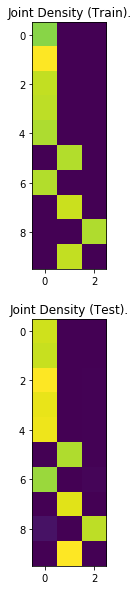

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(20, 10))

cm_tr = joint_density(y_tr, L[I_tr], nY=10, nL=3)
cm_te = joint_density(preds, L[I_te], nY=10, nL=3)

gsave(dict(cm_tr=cm_tr, cm_te=cm_te), 'gs://ANONYMOUS/results/nde/kernels/conf/fmnist3/gauss_n5000_s0.1')

# plot_confusion(cm_tr, ax=axs[0], display_labels=None)
# axs[0].set_title(f'Joint Density (Train).');
# plot_confusion(cm_te, ax=axs[1], display_labels=None)
# axs[1].set_title(f'Joint Density (Test).');

axs[0].imshow(cm_tr)
axs[0].set_title(f'Joint Density (Train).');

axs[1].imshow(cm_te)
axs[1].set_title(f'Joint Density (Test).');

In [1]:
print(cm_tr)

NameError: name 'cm_tr' is not defined

In [21]:
print(cm_te)

[[9.800e-02 1.000e-04 2.000e-04]
 [9.660e-02 0.000e+00 0.000e+00]
 [1.052e-01 0.000e+00 8.000e-04]
 [1.020e-01 2.000e-04 6.000e-04]
 [1.028e-01 0.000e+00 6.000e-04]
 [3.000e-04 9.290e-02 7.000e-04]
 [8.980e-02 0.000e+00 1.600e-03]
 [0.000e+00 1.008e-01 4.000e-04]
 [5.300e-03 4.000e-04 9.490e-02]
 [0.000e+00 1.056e-01 2.000e-04]]


In [22]:
0.5*np.abs(cm_te - cm_tr).sum()

0.0338